## Classification on imbalanced data
#### Author: Francesca Naretto

In [48]:
import pandas as pd
import numpy as np

import pandas as pd
adult = pd.read_csv('./datasets/adult_imbalanced.csv')

In [49]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29817 entries, 0 to 29816
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Unnamed: 0          29817 non-null  int64
 1   age                 29817 non-null  int64
 2   fnlwgt              29817 non-null  int64
 3   education-num       29817 non-null  int64
 4   capital-gain        29817 non-null  int64
 5   capital-loss        29817 non-null  int64
 6   hours-per-week      29817 non-null  int64
 7   relationship_num    29817 non-null  int64
 8   race_num            29817 non-null  int64
 9   sex_num             29817 non-null  int64
 10  occupation_num      29817 non-null  int64
 11  marital-status_num  29817 non-null  int64
 12  workclass_num       29817 non-null  int64
 13  native-country_num  29817 non-null  int64
 14  label_num           29817 non-null  int64
dtypes: int64(15)
memory usage: 3.4 MB


Let's check how data are distributed

In [50]:
adult['label_num'].value_counts(True)

0    0.829057
1    0.170943
Name: label_num, dtype: float64

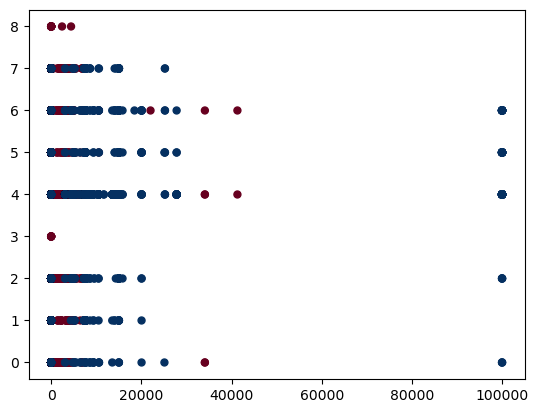

In [51]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.scatter(adult['capital-gain'].values, adult['workclass_num'].values, c=adult['label_num'].values, s=25, cmap='RdBu');

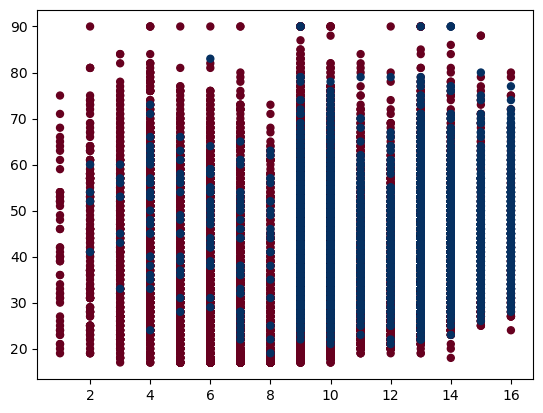

In [52]:
plt.scatter(adult['education-num'].values, adult['age'].values, c=adult['label_num'].values, s=25, cmap='RdBu');

In [53]:
from sklearn.model_selection import train_test_split
label = adult.pop('label_num')
train_set, test_set, train_label, test_label = train_test_split(adult, label, stratify =label, test_size=0.30)

### DecisionTree

In [7]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=10, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

In [8]:
from sklearn.metrics import classification_report
test_pred = dt.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.91      0.96      0.93      7417
         >50       0.72      0.53      0.61      1529

    accuracy                           0.88      8946
   macro avg       0.81      0.74      0.77      8946
weighted avg       0.88      0.88      0.88      8946



The recall for class >50 is 0.53. This is due to the fact that the dataset is imablanced.
Let's try a different classifier.

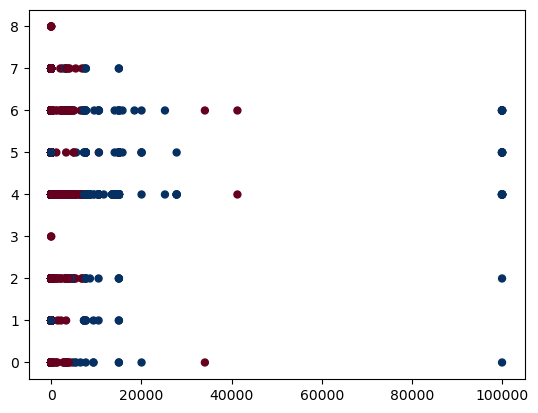

In [9]:
plt.scatter(test_set['capital-gain'].values, test_set['workclass_num'].values, c=test_label.values, s=25, cmap='RdBu');

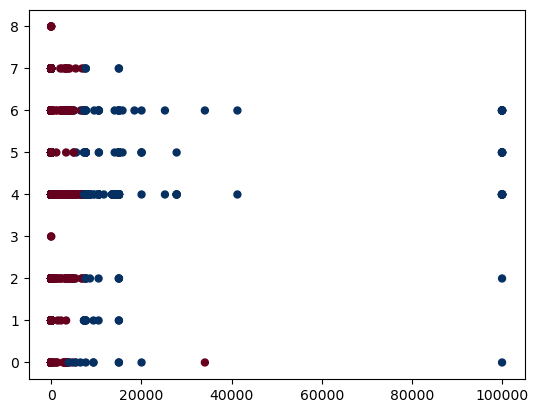

In [10]:
plt.scatter(test_set['capital-gain'].values, test_set['workclass_num'].values, c=test_pred, s=25, cmap='RdBu');

### SVM

In [11]:
from sklearn.svm import SVC
svm = SVC(gamma='scale')
svm.fit(train_set, train_label)

SVC()

In [12]:
test_pred = svm.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.84      1.00      0.91      7417
         >50       0.96      0.10      0.18      1529

    accuracy                           0.85      8946
   macro avg       0.90      0.55      0.55      8946
weighted avg       0.86      0.85      0.79      8946



### AdaBoost

In [13]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(train_set, train_label)

AdaBoostClassifier()

In [14]:
test_pred = clf.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.91      0.97      0.94      7417
         >50       0.76      0.53      0.62      1529

    accuracy                           0.89      8946
   macro avg       0.83      0.75      0.78      8946
weighted avg       0.88      0.89      0.88      8946



Even if with AdaBoost we can obtain a better result, the perfomance are still suffering from the great imbalance. Let's see possible solutions.

### Weights to the model

We can give weights to the model, in this way we can say that the examples of a given class are more important, hence if an error occurs, it is worst than an error for the other class. 
This approach is available in any classifier from sklearn and keras, pytorch.

In [15]:
weights = {0:1.0, 1:100.0}
svm = SVC(gamma='scale', class_weight=weights)
svm.fit(train_set, train_label)

SVC(class_weight={0: 1.0, 1: 100.0})

In [16]:
test_pred = svm.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       1.00      0.00      0.00      7417
         >50       0.17      1.00      0.29      1529

    accuracy                           0.17      8946
   macro avg       0.59      0.50      0.15      8946
weighted avg       0.86      0.17      0.05      8946



Clearly, these weights are not well suited for the problem at hand. We can run a grid search to see what combination of weights is better in this setting.

In [17]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:10}, 'balanced']
param_grid = dict(class_weight=balance)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [18]:
grid_result = grid_search.fit(test_set, test_label)

In [19]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.611885 using {'class_weight': 'balanced'}
0.453942 (0.031402) with: {'class_weight': {0: 100, 1: 1}}
0.603726 (0.026746) with: {'class_weight': {0: 10, 1: 1}}
0.567589 (0.024245) with: {'class_weight': {0: 1, 1: 10}}
0.611885 (0.030785) with: {'class_weight': 'balanced'}


In [20]:
svm = SVC(gamma='scale', class_weight='balanced')
svm.fit(train_set, train_label)

SVC(class_weight='balanced')

In [21]:
test_pred = svm.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.86      0.99      0.92      7417
         >50       0.83      0.19      0.31      1529

    accuracy                           0.85      8946
   macro avg       0.84      0.59      0.61      8946
weighted avg       0.85      0.85      0.81      8946



### Undersampling or Oversampling 

In [22]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
#duplicate
oversample = RandomOverSampler(sampling_strategy='minority')
adult_o, label_o = oversample.fit_resample(train_set, train_label)


In [23]:
label_o.value_counts(True)

0    0.5
1    0.5
Name: label_num, dtype: float64

In [24]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
adult_u, label_u = undersample.fit_resample(train_set, train_label)

In [25]:
label_u.value_counts(True)

0    0.5
1    0.5
Name: label_num, dtype: float64

In [26]:
oversample = RandomOverSampler(sampling_strategy=0.60)
adult_o_o, label_o_o = oversample.fit_resample(train_set, train_label)
undersample = RandomUnderSampler(sampling_strategy=0.70)
adult_o_u, label_o_u = undersample.fit_resample(adult_o_o, label_o_o)

In [27]:
label_o_u.value_counts(True)

0    0.588235
1    0.411765
Name: label_num, dtype: float64

In [28]:
clf = AdaBoostClassifier()
clf.fit(adult_o, label_o)
test_pred = clf.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.96      0.80      0.88      7417
         >50       0.47      0.85      0.61      1529

    accuracy                           0.81      8946
   macro avg       0.72      0.83      0.74      8946
weighted avg       0.88      0.81      0.83      8946



In [29]:
clf = AdaBoostClassifier()
clf.fit(adult_u, label_u)
test_pred = clf.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.96      0.81      0.88      7417
         >50       0.47      0.84      0.60      1529

    accuracy                           0.81      8946
   macro avg       0.72      0.82      0.74      8946
weighted avg       0.88      0.81      0.83      8946



In [30]:
clf = AdaBoostClassifier()
clf.fit(adult_o_u, label_o_u)
test_pred = clf.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.95      0.86      0.90      7417
         >50       0.53      0.77      0.63      1529

    accuracy                           0.84      8946
   macro avg       0.74      0.82      0.76      8946
weighted avg       0.88      0.84      0.85      8946



In [31]:
clf = SVC()
clf.fit(adult_o_u, label_o_u)
test_pred = clf.predict(adult_o_u)
print(classification_report(label_o_u, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.63      0.99      0.77     14830
         >50       0.95      0.18      0.30     10381

    accuracy                           0.66     25211
   macro avg       0.79      0.58      0.54     25211
weighted avg       0.76      0.66      0.58     25211



In [32]:
oversample = RandomOverSampler(sampling_strategy=0.30)
adult_o, label_o = oversample.fit_resample(train_set, train_label)

In [33]:
label_o.value_counts(True)

0    0.769262
1    0.230738
Name: label_num, dtype: float64

In [34]:
clf = SVC()
clf.fit(adult_o, label_o)
test_pred = clf.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.85      1.00      0.92      7417
         >50       0.97      0.13      0.24      1529

    accuracy                           0.85      8946
   macro avg       0.91      0.57      0.58      8946
weighted avg       0.87      0.85      0.80      8946



In [35]:
undersample = RandomUnderSampler(sampling_strategy=0.30)
adult_u, label_u = undersample.fit_resample(train_set, train_label)

In [36]:
clf = SVC()
clf.fit(adult_u, label_u)
test_pred = clf.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.85      1.00      0.92      7417
         >50       0.97      0.12      0.21      1529

    accuracy                           0.85      8946
   macro avg       0.91      0.56      0.56      8946
weighted avg       0.87      0.85      0.79      8946



### SMOTE

In [38]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.3)
adult_s, label_s = oversample.fit_resample(train_set, train_label)

In [39]:
clf = SVC(kernel='sigmoid', gamma='scale')
clf.fit(adult_s, label_s)
test_pred = clf.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.83      0.78      0.81      7417
         >50       0.19      0.25      0.22      1529

    accuracy                           0.69      8946
   macro avg       0.51      0.52      0.51      8946
weighted avg       0.72      0.69      0.71      8946



In [57]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=1, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(adult_s, adult_s)
test_pred_dt = dt.predict(test_set)
print(classification_report(test_label, test_pred_dt, target_names=['<=50', '>50']))

In [44]:
oversample = SMOTE(sampling_strategy=0.3)
adult_s, label_s = oversample.fit_resample(train_set, train_label)
undersample = RandomUnderSampler(sampling_strategy=0.40)
adult_s_u, label_s_u = undersample.fit_resample(adult_s, label_s)

In [45]:
clf = AdaBoostClassifier()
clf.fit(adult_s_u, label_s_u)
clf.predict(test_set)
print(classification_report(test_label, test_pred, target_names=['<=50', '>50']))

              precision    recall  f1-score   support

        <=50       0.83      0.78      0.81      7417
         >50       0.19      0.25      0.22      1529

    accuracy                           0.69      8946
   macro avg       0.51      0.52      0.51      8946
weighted avg       0.72      0.69      0.71      8946

